In [50]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [51]:
def read_json_file(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return data


def get_zeros(data):
    zeros = []
    for i in range(len(data["scores"])):
        if data["scores"][i]["label"] == 0:
            zeros.append(data["scores"][i]["score"])
    return zeros

def get_ones(data):
    ones = []
    for i in range(len(data["scores"])):
        if data["scores"][i]["label"] == 1:
            ones.append(data["scores"][i]["score"])
    return ones

def get_labels(data):
    labels = []
    for i in range(len(data["scores"])):
        labels.append(data["scores"][i]["label"])
    return labels

In [52]:
def plot_scores(stats_dir):
    stats_files = os.listdir(stats_dir)
    num_rows = int(np.ceil(len(stats_files) / 3))
    for i, filename in enumerate(os.listdir(stats_dir)):
        if filename.endswith(".json"):
            json_file = os.path.join(stats_dir, filename)
            data = read_json_file(json_file)
            zeros = get_zeros(data)
            ones = get_ones(data)
            title = filename.split(".")[0]

            if "test" in  stats_dir:
                plt.rcParams["figure.figsize"] = (15, 5)
                plt.suptitle("Test", fontsize=20)
            else:
                plt.rcParams["figure.figsize"] = (20, 10)
                plt.suptitle("Train", fontsize=20)
                plt.subplots_adjust(wspace=0.25, hspace=0.25)
                plt.subplot(num_rows, 3, i + 1, title=title, xlabel="scores", ylabel="num")

            mean_zeros = np.mean(zeros)
            mean_ones = np.mean(ones)
            std_zeros = np.std(zeros)
            std_ones = np.std(ones)

            step = len(zeros)
            x = np.linspace(0, 1, step)

            pdf_zeros = norm.pdf(x, mean_zeros, std_zeros)
            pdf_ones = norm.pdf(x, mean_ones, std_ones)
            idx = np.argwhere(np.diff(np.sign(pdf_zeros - pdf_ones))).flatten()

            plt.plot(np.linspace(0, 1, step), pdf_zeros, color="r", linewidth=2)
            plt.plot(np.linspace(0, 1, step), pdf_ones, color="b", linewidth=2)

            plt.axvline(x=x[idx], color="g", linestyle="--", linewidth=2)
            plt.text(x[idx] + 0.01, 0.5, f"th_eer={x[idx][0]:.3f}", rotation=90, fontsize=12)
            plt.title(f"{title}, eer={data['m_eer']:.3f}, acc={data['m_acc']:.3f}", fontsize=12)

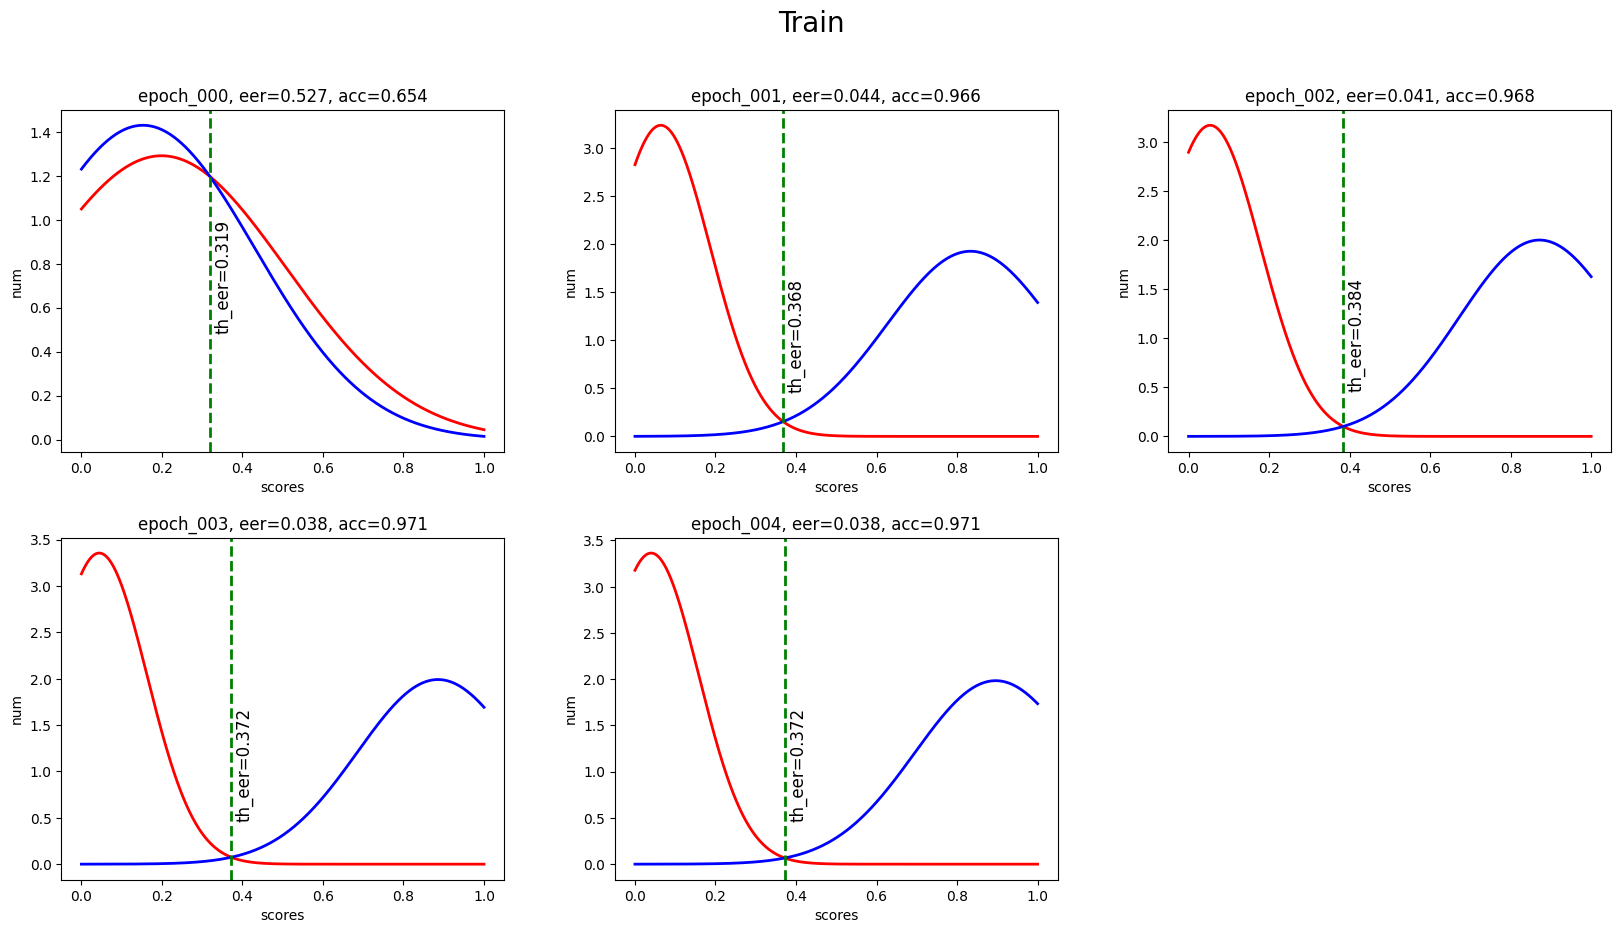

In [53]:
stats_dir = "../logs/stats/val_base"
plot_scores(stats_dir)

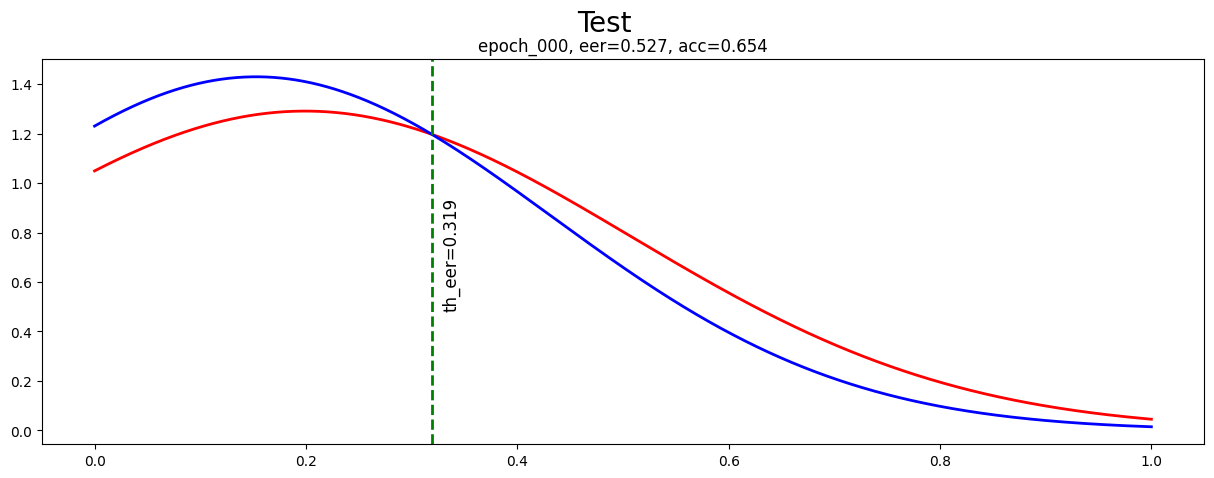

In [54]:
stats_dir = "../logs/stats/test"
plot_scores(stats_dir)